In [1]:
##############################################################################################################
# DESCRIPTION: 
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

class HyperParams:
    pass

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

IMG_PATH_TRAIN = IMG_PATH

hyperparams = HyperParams()
hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 350
hyperparams.BATCH_SIZE = 16

hyperparams.NUM_CHANNELS = 32
hyperparams.NUM_RES_BLOCKS = 5

hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0010_10000"
MODEL_NAME = "0010_1000-64-resnet-xxh"

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0299
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.4778

from tensorflow.keras.optimizers import Nadam
hyperparams.OPTIMIZER = Nadam(learning_rate=0.0001)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelD as train
import ReportsK as reports
import ResnetBatchE as model_factory

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7095412755670424232
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1883930624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12872928836053939716
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]
Tensorflow version: 2.6.0
Keras Version: 2.6.0
GPU is available


In [5]:
##################
# MODEL DEFINITION
##################

model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

{'name': 'Nadam',
 'learning_rate': 0.0001,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [6]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT)

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/
Noisy files:20137
Nitid files:20137
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/validation/
Noisy files:4872
Nitid files:4872


In [7]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

checkpoint_filepath = os.path.abspath(os.path.join('../../../saves/') + MODEL_NAME \
                                      + "_checkpoint_" + '_weights_{epoch:02d}-{val_loss:.2f}')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 50, \
                 callbacks=[model_checkpoint_callback] )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/350
1259/1259 [==============================] - 233s 173ms/step - loss: 0.1583 - val_loss: 0.0700
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-resnet-xxh_checkpoint__weights_01-0.07\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0769 - val_loss: 0.0643
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-resnet-xxh_checkpoint__weights_02-0.06\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0725 - val_loss: 0.0679
Epoch 4/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0702 - val_loss: 0.0622
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-resnet-xxh_checkpoint__weights_04-0.06\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0686 - val_loss: 0.0637
Epoch 6/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0672 - val_loss: 0.0647
Epoch 7/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0661 - val_loss: 0.0589
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-resnet-xxh_checkpoint__weights_07-0.06\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0652 - val_loss: 0.0611
Epoch 9/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0645 - val_loss: 0.0596
Epoch 10/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0639 - val_loss: 0.0596
Epoch 11/350
1259/1259 [==============================] - 219s 174ms/step - loss: 0.0635 - val_loss: 0.0594
Epoch 12/350
1259/1259 [==============================] - 217s 172ms/step - loss: 0.0631 - val_loss: 0.0624
Epoch 13/350
1259/1259 [==============================] - 220s 175ms/step - loss: 0.0627 - val_loss: 0.0611
Epoch 14/350
1259/1259 [==============================] - 221s 176ms/step - loss: 0.0622 - val_loss: 0.0596
Epoch 15/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0618 - val_loss: 0.0605
Epoch 16/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0618 - val_loss: 0.0598
Epoch 17/350
1259/1259 [======

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0610 - val_loss: 0.0604
Epoch 19/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0611 - val_loss: 0.0614
Epoch 20/350
1259/1259 [==============================] - 216s 172ms/step - loss: 0.0605 - val_loss: 0.0628
Epoch 21/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0604 - val_loss: 0.0611
Epoch 22/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0601 - val_loss: 0.0581
Epoch 23/350
1259/1259 [==============================] - 216s 172ms/step - loss: 0.0601 - val_loss: 0.0590
Epoch 24/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0598 - val_loss: 0.0571
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-resnet-xxh_checkpoint__weights_24-0.06\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0597 - val_loss: 0.0568
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-resnet-xxh_checkpoint__weights_25-0.06\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0593 - val_loss: 0.0579
Epoch 27/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0594 - val_loss: 0.0570
Epoch 28/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0592 - val_loss: 0.0585
Epoch 29/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0589 - val_loss: 0.0601
Epoch 30/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0590 - val_loss: 0.0545
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-resnet-xxh_checkpoint__weights_30-0.05\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0586 - val_loss: 0.0553
Epoch 32/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0586 - val_loss: 0.0559
Epoch 33/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0584 - val_loss: 0.0589
Epoch 34/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0584 - val_loss: 0.0576
Epoch 35/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0582 - val_loss: 0.0562
Epoch 36/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0582 - val_loss: 0.0573
Epoch 37/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0579 - val_loss: 0.0601
Epoch 38/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0581 - val_loss: 0.0572
Epoch 39/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0578 - val_loss: 0.0548
Epoch 40/350
1259/1259 [====

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 56/350
1259/1259 [==============================] - 216s 171ms/step - loss: 0.0565 - val_loss: 0.0557
Epoch 57/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0565 - val_loss: 0.0546
Epoch 58/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0564 - val_loss: 0.0541
Epoch 59/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0564 - val_loss: 0.0562
Epoch 60/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0564 - val_loss: 0.0545
Epoch 61/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0563 - val_loss: 0.0543
Epoch 62/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0562 - val_loss: 0.0572
Epoch 63/350
1259/1259 [==============================] - 221s 176ms/step - loss: 0.0561 - val_loss: 0.0574
Epoch 64/350
1259/1259 [==============================] - 222s 177ms/step - loss: 0.0560 - val_loss: 0.0555
Epoch 65/350
1259/1259 [====

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 70/350
1259/1259 [==============================] - 220s 174ms/step - loss: 0.0557 - val_loss: 0.0544
Epoch 71/350
1259/1259 [==============================] - 219s 174ms/step - loss: 0.0556 - val_loss: 0.0580
Epoch 72/350
1259/1259 [==============================] - 219s 174ms/step - loss: 0.0557 - val_loss: 0.0528
Epoch 73/350
1259/1259 [==============================] - 218s 174ms/step - loss: 0.0555 - val_loss: 0.0533
Epoch 74/350
1259/1259 [==============================] - 219s 174ms/step - loss: 0.0555 - val_loss: 0.0575
Epoch 75/350
1259/1259 [==============================] - 219s 174ms/step - loss: 0.0554 - val_loss: 0.0535
Epoch 76/350
1259/1259 [==============================] - 219s 174ms/step - loss: 0.0554 - val_loss: 0.0551
Epoch 77/350
1259/1259 [==============================] - 220s 175ms/step - loss: 0.0555 - val_loss: 0.0542
Epoch 78/350
1259/1259 [==============================] - 218s 173ms/step - loss: 0.0554 - val_loss: 0.0554
Epoch 79/350
1259/1259 [====

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 86/350
1259/1259 [==============================] - 217s 172ms/step - loss: 0.0550 - val_loss: 0.0520
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-resnet-xxh_checkpoint__weights_86-0.05\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 87/350
1259/1259 [==============================] - 218s 173ms/step - loss: 0.0551 - val_loss: 0.0575
Epoch 88/350
1259/1259 [==============================] - 217s 173ms/step - loss: 0.0548 - val_loss: 0.0540
Epoch 89/350
1259/1259 [==============================] - 217s 172ms/step - loss: 0.0549 - val_loss: 0.0603
Epoch 90/350
1259/1259 [==============================] - 217s 172ms/step - loss: 0.0549 - val_loss: 0.0539
Epoch 91/350
1259/1259 [==============================] - 217s 173ms/step - loss: 0.0548 - val_loss: 0.0546
Epoch 92/350
1259/1259 [==============================] - 217s 173ms/step - loss: 0.0549 - val_loss: 0.0578
Epoch 93/350
1259/1259 [==============================] - 217s 172ms/step - loss: 0.0548 - val_loss: 0.0564
Epoch 94/350
1259/1259 [==============================] - 217s 172ms/step - loss: 0.0546 - val_loss: 0.0544
Epoch 95/350
1259/1259 [==============================] - 217s 173ms/step - loss: 0.0546 - val_loss: 0.0543
Epoch 96/350
1259/1259 [====

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 112/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0541 - val_loss: 0.0604
Epoch 113/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0541 - val_loss: 0.0564
Epoch 114/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0542 - val_loss: 0.0538
Epoch 115/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0540 - val_loss: 0.0556
Epoch 116/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0539 - val_loss: 0.0569
Epoch 117/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0541 - val_loss: 0.0556
Epoch 118/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0539 - val_loss: 0.0541
Epoch 119/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0539 - val_loss: 0.0540
Epoch 120/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0539 - val_loss: 0.0535
Epoch 121/350
1259/

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 131/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0536 - val_loss: 0.0548
Epoch 132/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0536 - val_loss: 0.0527
Epoch 133/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0537 - val_loss: 0.0566
Epoch 134/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0535 - val_loss: 0.0577
Epoch 135/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0535 - val_loss: 0.0537
Epoch 136/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0535 - val_loss: 0.0544
Epoch 137/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0535 - val_loss: 0.0538
Epoch 138/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0535 - val_loss: 0.0524
Epoch 139/350
1259/1259 [==============================] - 215s 171ms/step - loss: 0.0533 - val_loss: 0.0563
Epoch 140/350
1259/

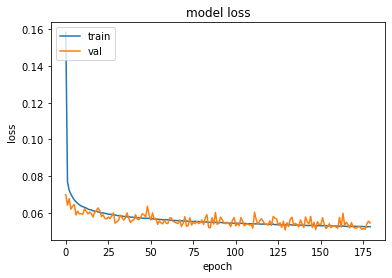

Best Epoch:130


In [8]:
##################
# REPORTS
##################
reports.plotHistory( hist )

In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-resnet-xxh\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [10]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Black image found
Black image found
Black image found
Black image found
Images count =4872
Best RMSENZ  =4302 (0.88)
Best MAENZ   =4335 (0.89)
Best PSNR    =4302 (0.88)
Best Accuracy=4496 (0.92)
RMSE-NZ  Pred=0.0614  Noisy=0.1609
MAE-NZ   Pred=0.0511  Noisy=0.1527
PSNR     Pred=15.1 dB Noisy=7.1 dB
Accuracy Pred=0.24    Noisy=0.08
SSM      Pred=0.84    Noisy=0.45
HOG MSE  Pred=0.14    Noisy=0.21


In [11]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test/
Noisy files:15
Nitid files:15
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_1_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_1_nitid_idx076.tif


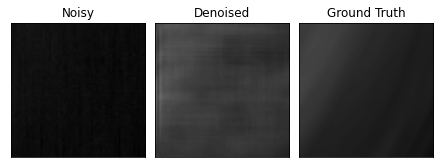

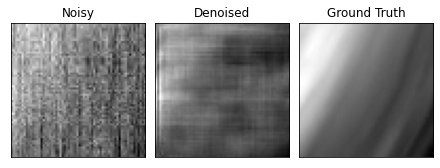

RMSE-NZ  Pred=0.0878  Noisy=0.1093 BEST
MAE-NZ   Pred=0.0842  Noisy=0.1013 BEST
PSNR     Pred=9.7 dB Noisy=7.7 dB BEST
Accuracy Pred=0.00    Noisy=0.00 BEST
SSM      Pred=0.83    Noisy=0.34
HOG MSE  Pred=0.35    Noisy=0.40
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_2_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_2_nitid_idx076.tif


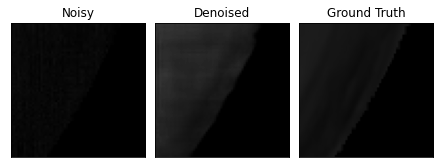

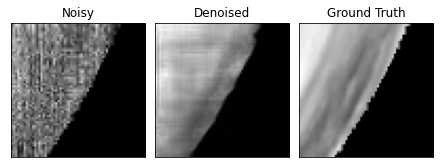

RMSE-NZ  Pred=0.0479  Noisy=0.0422 WORST
MAE-NZ   Pred=0.0338  Noisy=0.0346 BEST
PSNR     Pred=8.0 dB Noisy=9.1 dB WORST
Accuracy Pred=0.45    Noisy=0.23 BEST
SSM      Pred=0.83    Noisy=0.59
HOG MSE  Pred=0.08    Noisy=0.05
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_01_00_8_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_01_00_8_nitid_idx076.tif


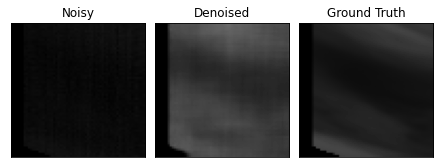

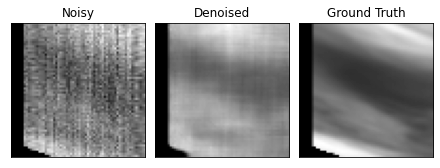

RMSE-NZ  Pred=0.1139  Noisy=0.0976 WORST
MAE-NZ   Pred=0.1049  Noisy=0.0842 WORST
PSNR     Pred=7.7 dB Noisy=9.1 dB WORST
Accuracy Pred=0.08    Noisy=0.00 BEST
SSM      Pred=0.71    Noisy=0.28
HOG MSE  Pred=0.10    Noisy=0.23
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_00_5_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_00_5_nitid_idx076.tif


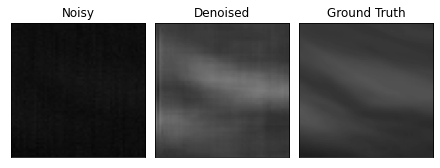

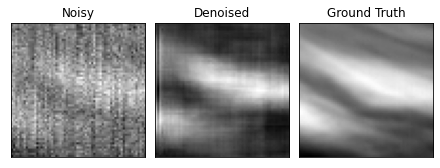

RMSE-NZ  Pred=0.0645  Noisy=0.1790 BEST
MAE-NZ   Pred=0.0544  Noisy=0.1749 BEST
PSNR     Pred=14.3 dB Noisy=5.4 dB BEST
Accuracy Pred=0.11    Noisy=0.00 BEST
SSM      Pred=0.88    Noisy=0.34
HOG MSE  Pred=0.12    Noisy=0.46
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_01_6_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_01_6_nitid_idx076.tif


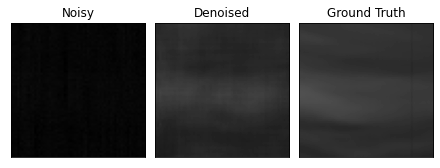

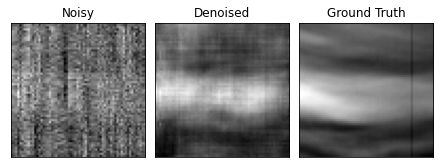

RMSE-NZ  Pred=0.0419  Noisy=0.1861 BEST
MAE-NZ   Pred=0.0379  Noisy=0.1834 BEST
PSNR     Pred=17.5 dB Noisy=4.6 dB BEST
Accuracy Pred=0.05    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.26
HOG MSE  Pred=0.13    Noisy=0.39
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_00_4_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_00_4_nitid_idx076.tif


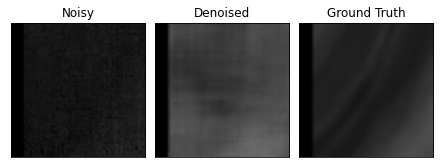

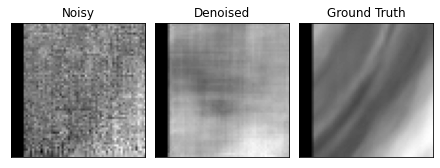

RMSE-NZ  Pred=0.1277  Noisy=0.0728 WORST
MAE-NZ   Pred=0.1154  Noisy=0.0602 WORST
PSNR     Pred=7.6 dB Noisy=12.4 dB WORST
Accuracy Pred=0.08    Noisy=0.04 BEST
SSM      Pred=0.69    Noisy=0.44
HOG MSE  Pred=0.14    Noisy=0.17
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_01_13_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_01_13_nitid_idx076.tif


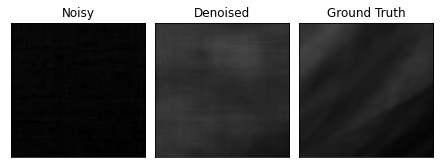

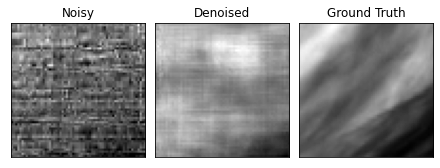

RMSE-NZ  Pred=0.0739  Noisy=0.1143 BEST
MAE-NZ   Pred=0.0642  Noisy=0.1044 BEST
PSNR     Pred=11.3 dB Noisy=7.5 dB BEST
Accuracy Pred=0.09    Noisy=0.00 BEST
SSM      Pred=0.74    Noisy=0.21
HOG MSE  Pred=0.15    Noisy=0.21
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_01_00_3_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_01_00_3_nitid_idx076.tif


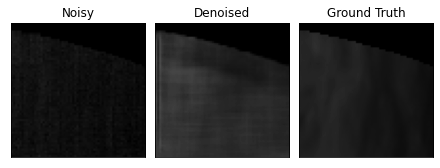

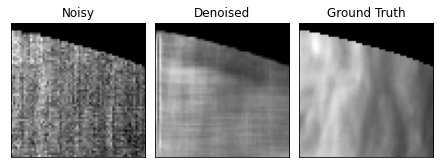

RMSE-NZ  Pred=0.0686  Noisy=0.0540 WORST
MAE-NZ   Pred=0.0564  Noisy=0.0470 WORST
PSNR     Pred=8.5 dB Noisy=10.6 dB WORST
Accuracy Pred=0.21    Noisy=0.08 BEST
SSM      Pred=0.78    Noisy=0.54
HOG MSE  Pred=0.11    Noisy=0.06
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_11_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_11_nitid_idx076.tif


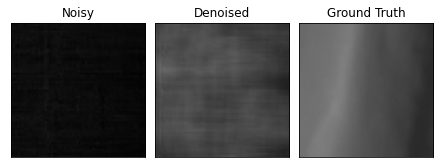

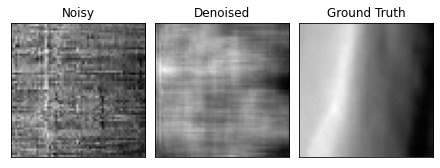

RMSE-NZ  Pred=0.1066  Noisy=0.3118 BEST
MAE-NZ   Pred=0.0853  Noisy=0.2974 BEST
PSNR     Pred=13.7 dB Noisy=4.4 dB BEST
Accuracy Pred=0.11    Noisy=0.00 BEST
SSM      Pred=0.75    Noisy=0.27
HOG MSE  Pred=0.27    Noisy=0.36
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_9_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_9_nitid_idx076.tif


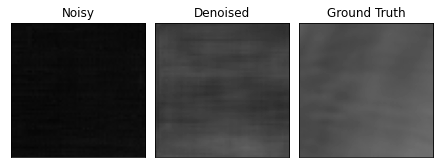

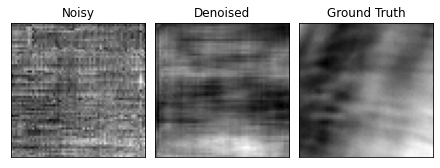

RMSE-NZ  Pred=0.0897  Noisy=0.2883 BEST
MAE-NZ   Pred=0.0785  Noisy=0.2864 BEST
PSNR     Pred=13.7 dB Noisy=3.5 dB BEST
Accuracy Pred=0.03    Noisy=0.00 BEST
SSM      Pred=0.83    Noisy=0.32
HOG MSE  Pred=0.11    Noisy=0.06
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_7_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_7_nitid_idx076.tif


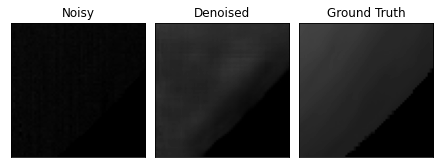

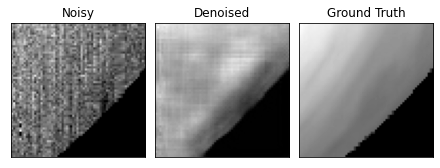

RMSE-NZ  Pred=0.0354  Noisy=0.1343 BEST
MAE-NZ   Pred=0.0262  Noisy=0.1226 BEST
PSNR     Pred=17.7 dB Noisy=6.2 dB BEST
Accuracy Pred=0.35    Noisy=0.11 BEST
SSM      Pred=0.89    Noisy=0.44
HOG MSE  Pred=0.08    Noisy=0.19
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_8_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_8_nitid_idx076.tif


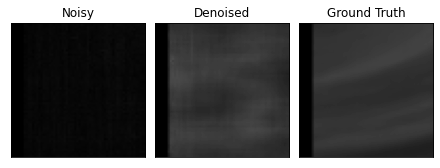

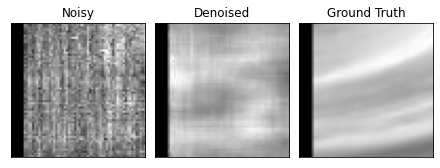

RMSE-NZ  Pred=0.0275  Noisy=0.1755 BEST
MAE-NZ   Pred=0.0216  Noisy=0.1729 BEST
PSNR     Pred=19.6 dB Noisy=3.5 dB BEST
Accuracy Pred=0.32    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.23
HOG MSE  Pred=0.10    Noisy=0.25
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0242_08_00_15_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0242_08_00_15_nitid_idx076.tif


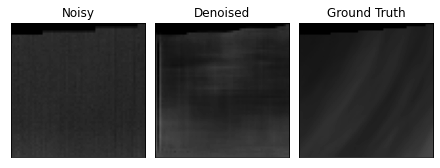

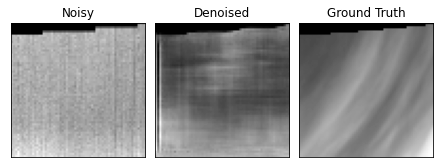

RMSE-NZ  Pred=0.0468  Noisy=0.0385 WORST
MAE-NZ   Pred=0.0343  Noisy=0.0294 WORST
PSNR     Pred=15.6 dB Noisy=17.3 dB WORST
Accuracy Pred=0.22    Noisy=0.25 WORST
SSM      Pred=0.76    Noisy=0.77
HOG MSE  Pred=0.17    Noisy=0.12
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0272_04_00_9_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0272_04_00_9_nitid_idx076.tif


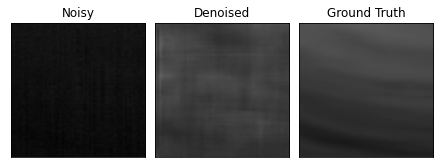

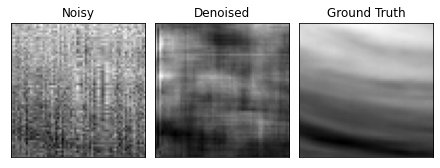

RMSE-NZ  Pred=0.0551  Noisy=0.1778 BEST
MAE-NZ   Pred=0.0478  Noisy=0.1697 BEST
PSNR     Pred=16.2 dB Noisy=6.0 dB BEST
Accuracy Pred=0.09    Noisy=0.00 BEST
SSM      Pred=0.84    Noisy=0.39
HOG MSE  Pred=0.45    Noisy=0.49
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0376_06_01_13_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0376_06_01_13_nitid_idx076.tif


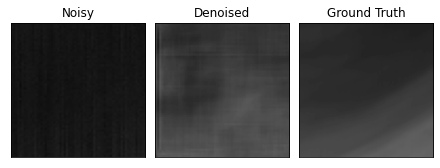

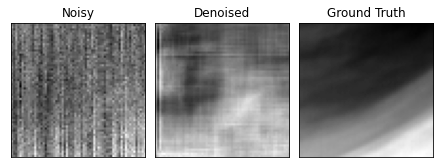

RMSE-NZ  Pred=0.0582  Noisy=0.1427 BEST
MAE-NZ   Pred=0.0500  Noisy=0.1285 BEST
PSNR     Pred=16.6 dB Noisy=8.8 dB BEST
Accuracy Pred=0.10    Noisy=0.00 BEST
SSM      Pred=0.81    Noisy=0.50
HOG MSE  Pred=0.18    Noisy=0.31
******************************************************


In [12]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
    dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
    dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )